In [1]:
import json
import os
from typing import Sequence

from absl import app
from absl import flags
from balloon_learning_environment.env import balloon_env  # pylint: disable=unused-import
from balloon_learning_environment.env.rendering import matplotlib_renderer
from balloon_learning_environment.env import features
from balloon_learning_environment.eval import eval_lib
from balloon_learning_environment.eval import suites
from balloon_learning_environment.utils import run_helpers
import gym

2024-10-04 20:37:24.616210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jnl77/.conda/envs/ble/lib/python3.9/site-packages/cv2/../../lib64:


In [2]:
RENDERERS = {
    'matplotlib': matplotlib_renderer.MatplotlibRenderer,
}

FEATURE_CONSTRUCTORS = {
  'perciatelli': features.PerciatelliFeatureConstructor,
  'mpc': features.MPCFeatures
}

class Options:
    def __init__(self):
        # The type of feature constructor, can be 'perciatelli' or 'mpc'
        self.feature_constructor = 'perciatelli'
        
        # The name of the agent to create, e.g., 'dqn'
        self.agent = 'dqn'
        
        # The evaluation suite to run, from available suites
        self.suite = 'big_eval'
        
        # The wind field type to use, options defined in _WIND_FIELDS dict
        self.wind_field = 'generative'
        
        # Gin file for agent configuration (if any)
        self.agent_gin_file = None
        
        # Gin bindings to override default values (list of strings)
        self.gin_bindings = []
        
        # The directory to output the JSON summary
        self.output_dir = '/tmp/ble/eval'
        
        # The number of per-agent shards to split the eval job into
        self.num_shards = 1
        
        # The index of the current shard (must be >= 0)
        self.shard_idx = 0
        
        # If true, writes JSON files with an indent of 2
        self.pretty_json = False
        
        # The directory to load checkpoints from (if any)
        self.checkpoint_dir = None
        
        # The checkpoint iteration number to load (if any)
        self.checkpoint_idx = None
        
        # Overrides the default JSON output file name (if supplied)
        self.name_override = None
        
        # The renderer to use, None for no rendering
        self.renderer = None
        
        # The period to render with (only effective if renderer is not None)
        self.render_period = 10


FLAGS = Options() # Get the default options
FLAGS.feature_constructor = "mpc"
FLAGS.agent = "mpc"
FLAGS.suite = "micro_eval"
FLAGS.renderer = 'matplotlib'

In [3]:

def write_result(result: Sequence[eval_lib.EvaluationResult]) -> None:
  """Writes an evaluation result as a json file."""
  if FLAGS.name_override:
    file_name = FLAGS.name_override
  elif FLAGS.checkpoint_idx is not None:
    file_name = f'{FLAGS.agent}_{FLAGS.checkpoint_idx}'
  else:
    file_name = FLAGS.agent

  if FLAGS.num_shards > 1:
    file_name = f'{file_name}_{FLAGS.shard_idx}'
  file_name = f'{file_name}.json'

  dir_path = os.path.join(FLAGS.output_dir, FLAGS.suite)
  file_path = os.path.join(dir_path, file_name)

  indent = 2 if FLAGS.pretty_json else None


  os.makedirs(dir_path, exist_ok=True)
  with open(file_path, 'w') as f:
    json.dump(result, f, cls=eval_lib.EvalResultEncoder, indent=indent)


/home/jnl77/.conda/envs/ble/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


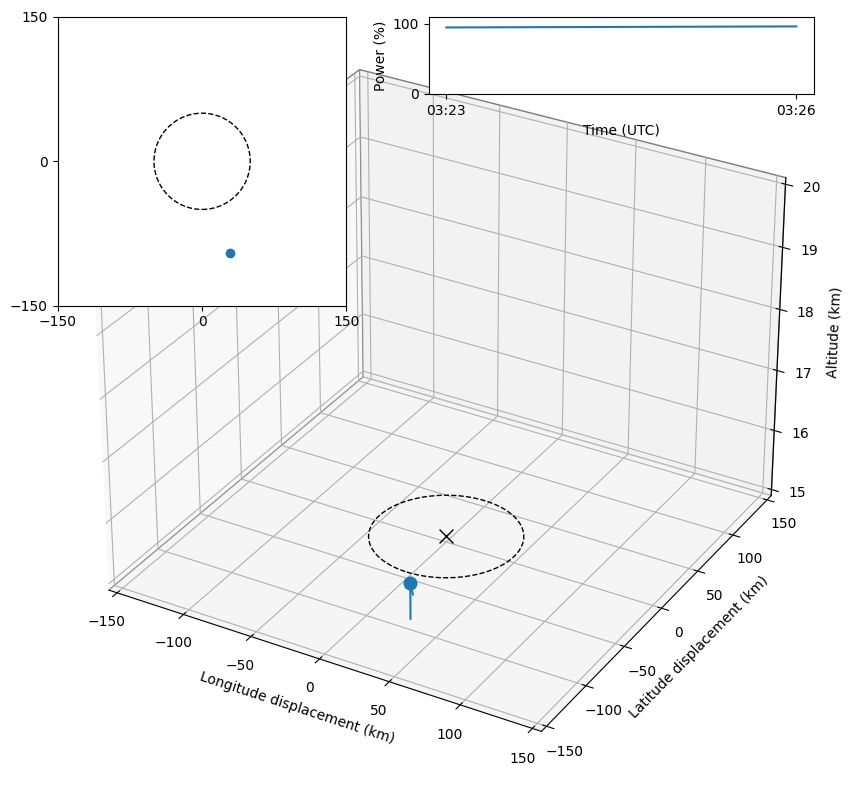

In [4]:
renderer = None
if FLAGS.renderer is not None:
    renderer = RENDERERS[FLAGS.renderer]()

fc_factory = FEATURE_CONSTRUCTORS[FLAGS.feature_constructor]
wf_factory = run_helpers.get_wind_field_factory(FLAGS.wind_field)
env = gym.make('BalloonLearningEnvironment-v0',
                wind_field_factory=wf_factory,
                renderer=renderer,
                feature_constructor_factory=fc_factory)

agent = run_helpers.create_agent(
    FLAGS.agent,
    env.action_space.n,
    observation_shape=env.observation_space.shape)

if FLAGS.checkpoint_dir is not None and FLAGS.checkpoint_idx is not None:
    agent.load_checkpoint(FLAGS.checkpoint_dir, FLAGS.checkpoint_idx)

eval_suite = suites.get_eval_suite(FLAGS.suite)

if FLAGS.num_shards > 1:
    start = int(len(eval_suite.seeds) * FLAGS.shard_idx / FLAGS.num_shards)
    end = int(len(eval_suite.seeds) * (FLAGS.shard_idx + 1) / FLAGS.num_shards)
    eval_suite.seeds = eval_suite.seeds[start:end]

eval_result = eval_lib.eval_agent(agent, env, eval_suite,
                            render_period=FLAGS.render_period)
write_result(eval_result)

